In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install pymc3>=3.8

We'll use Gelman et al.'s famous (2007) radon dataset. In this dataset, the amount of the radioactive gas radon has been measured among different households in all counties of the great state of Minnesota (MN). Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among different types of soil.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving radon.csv to radon (1).csv


In [5]:
radon = pd.read_csv('radon.csv', index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,,2,4.0,41,930.0,930.0,12088.0,12288.0,2.2,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,5,2.0,40,1615.0,1615.0,11888.0,12088.0,2.2,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,,3,2.0,42,1030.0,1515.0,20288.0,21188.0,2.9,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,,2,2.0,24,1410.0,1410.0,122987.0,123187.0,1.0,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,,3,2.0,40,600.0,600.0,12888.0,13088.0,3.1,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county: The county of Hennepin.

Why are we using the log of the Radon measurement? To squash the measurement as much as possible into a single order of magnitude.

Suppose we are interested in the following point statistics:

Whether the mean log-radon value is greater than 4 pCi/L in Hennepin county
The probability that any randomly-chosen household in Hennepin county has a reading of greater than 4
Greater than 4 means danger!!

What is the first thing we do in a data science problem?

Evaluate the histogram of the data so we can match it to a well-known statistical function.

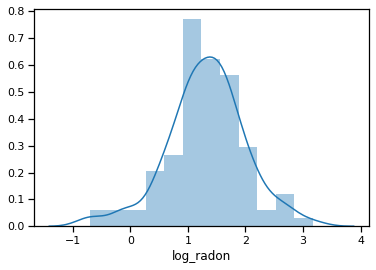

In [6]:
hennepin_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hennepin_radon)

In [7]:
# this confirms that a pdf is a function of *one* variable
hennepin_radon.shape

(105,)

# Pick the model profile

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge (about the priors), and specify a diffuse prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance,  102 , to allow the possibility of very large or very small values:

𝜇∼𝑁(0,102)
 
For the standard deviation, we know that the true value must be positive (no negative variances!). Let's choose a uniform pdf prior, bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take. That way, we are sure to capture the real value, somewhere in -between.

𝜎∼𝑈(0,10)
 
Note that I picked 0 as the mean for the pdf of the model parameters. That is a common practice.

In [0]:
from pymc3 import Model, Uniform, Normal

with Model() as radon_model:
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)

All that remains is to add the likelihood, which takes  𝜇  and  𝜎  as parameters, and the log-radon values as the set of observations:

In [0]:
with radon_model:    
    y = Normal('y', mu=μ, sd=σ, observed=hennepin_radon)

In [10]:
from pymc3 import fit

with radon_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 136.48: 100%|██████████| 10000/10000 [00:04<00:00, 2190.22it/s]
Finished [100%]: Average Loss = 136.37


In [20]:
!pip install arviz

  Using cached https://files.pythonhosted.org/packages/6c/23/73ae3b88a6837fa5a162d984acabfd2e75dc847ed67e5690aa44d02f491a/arviz-0.7.0-py3-none-any.whl


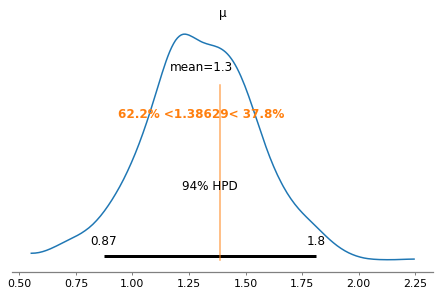

In [11]:
from pymc3 import plot_posterior

plot_posterior(samples, var_names=['μ'], ref_val=np.log(4));

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5f6932a58>],
      dtype=object)

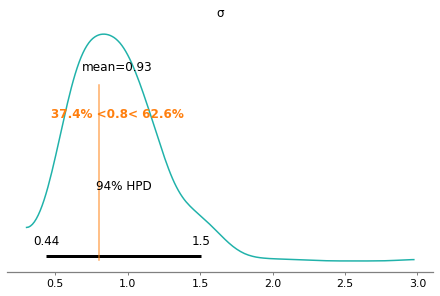

In [12]:
plot_posterior(samples, varnames=['σ'], ref_val=0.8, color='LightSeaGreen')

# Predictions

What is the probability that a given household has a log-radon measurement larger than one? To answer this, we make use of the posterior predictive distribution.

𝑝(𝑧|𝑦)=∫𝜃𝑝(𝑧|𝜃)𝑝(𝜃|𝑦)𝑑𝜃
 
where here  𝑧  is the predicted value and y is the data used to fit the model.

The posterior predictive distribution accounts for uncertainty about  𝜃 . We should refrain from plugging in a single best estimate  𝜃̂   for  𝜃 , because it ignores uncertainty about  𝜃 , and because a source of uncertainty is ignored, the predicted distribution will be too narrow (extreme values of  𝑥̃   will occur more often than the posterior distribution suggests).

The posterior distribution of possible  𝜃  values depends on  𝐗 :  𝑝(𝜃|𝐗) . And the posterior predictive distribution for any new datapoint  𝑥̃   given  𝐗  is calculated by marginalizing the distribution of  𝑥̃   given  𝜃  over the posterior distribution of  𝜃  given  𝐗 . That is the integral above.
We can estimate the probability that a given household has a log-radon measurement larger than one from the posterior samples of the parameters in the model:

In [0]:
mus = samples['μ']
sigmas = samples['σ']

In [0]:
radon_samples = Normal.dist(mus, sigmas).random()

In [15]:
(radon_samples > np.log(4)).mean()

0.479

The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is 0.43.

# Model checking

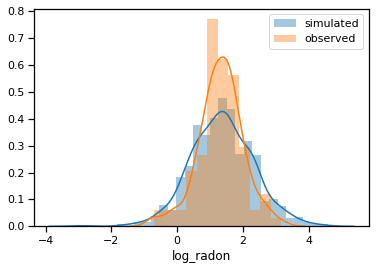

In [16]:
sns.distplot(radon_samples, label='simulated')
sns.distplot(hennepin_radon, label='observed')
plt.legend()

In [20]:
len(hennepin_radon)

105

# Prior Sensitivity 
A new model with different priors

In [21]:
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:

    μ = Flat('μ')
    σ = HalfCauchy('σ', 5)

    dist = Normal('dist', mu=μ, sd=σ, observed=hennepin_radon)

    sensitivity_samples = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 123.98: 100%|██████████| 10000/10000 [00:04<00:00, 2232.68it/s]
Finished [100%]: Average Loss = 123.94


/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5f4e1b3c8>],
      dtype=object)

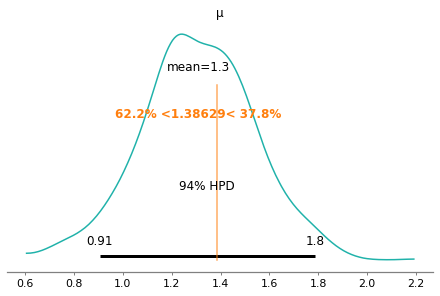

In [22]:
plot_posterior(sensitivity_samples, varnames=['μ'], ref_val=np.log(4), color='LightSeaGreen')

Here is the original model for comparison:

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6031654e0>],
      dtype=object)

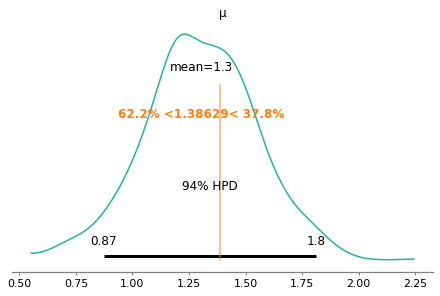

In [23]:
plot_posterior(samples, varnames=['μ'], ref_val=np.log(4), color='LightSeaGreen')

# Conclusion

The most difficult part of Bayesian estimation is the part that models the parameters of the pdf you picked as your model as pdfs themselves. You might think that it's picking the right statistical profile that matches the histogram of the dataset, but that's usually not that hard. Picking the shape of the pdf for each model parameter is harder because you don't have a physical profile to match! And then, you also need to pick initial conditions for these parameters.

It's all about experience! If you make the right choices (and that is often the art behind Bayesian inference), then Bayesian packages like PyMc3 will do all the work for you, and you will get a good model of your dataset, and then you can throw away all the historical data and use that model to do predictions. If you make the wrong choice, most often your computation won't converge or you will get very strange results. In which case, go watch an episode of GoT, then start from scratch.